In [1]:
import gym
import rospy
import numpy as np
import tensorflow as tf

from gym.envs.registration import register
from neuroracer_gym import neuroracer_env
from tf_agents.environments import tf_py_environment, utils
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer

# just to register env:
from neuroracer_gym.tasks.neuroracer_discrete_task import NeuroRacerTfAgents

None


In [2]:
rospy.init_node('neuroracer_qlearn', anonymous=True, log_level=rospy.INFO)

env = NeuroRacerTfAgents()
env_eval = NeuroRacerTfAgents(val=True)

print('action_spec:', env.action_spec())
print('time_step_spec.observation:', env.time_step_spec().observation)
print('time_step_spec.step_type:', env.time_step_spec().step_type)
print('time_step_spec.discount:', env.time_step_spec().discount)
print('time_step_spec.reward:', env.time_step_spec().reward)

[ERROR] [1609522860.754155, 0.000000]: NOT Initialising Simulation Physics Parameters
[WARN] [1609522860.757541, 0.000000]: Start Init ControllersConnection
[WARN] [1609522860.758352, 0.000000]: END Init ControllersConnection
[ERROR] [1609522863.128410, 2.068000]: NOT Initialising Simulation Physics Parameters
[WARN] [1609522863.133154, 2.068000]: Start Init ControllersConnection
[WARN] [1609522863.134753, 2.068000]: END Init ControllersConnection


action_spec: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)
time_step_spec.observation: BoundedArraySpec(shape=(40,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=10.0)
time_step_spec.step_type: ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')
time_step_spec.discount: BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0)
time_step_spec.reward: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [3]:
utils.validate_py_environment(env, episodes=3)

Cumulated Reward: -8.619360290831485
Cumulated Reward: -41.37939231710127
Cumulated Reward: -166.32034977677299


In [4]:
time_step = env.reset()

for _ in range(1):
    time_step = env.step(np.array(2, dtype=np.int32))
    print(time_step.reward)

cumulative_reward = time_step.reward

7.5693615e-06


In [5]:
print(env.observation_spec())
print(env.action_spec())

BoundedArraySpec(shape=(40,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=10.0)
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)


In [6]:
env = tf_py_environment.TFPyEnvironment(env)
env_eval = tf_py_environment.TFPyEnvironment(env_eval)

In [7]:
fc_layer_params = (100, )
dropout_layer_params = (0.15, )

q_net = q_network.QNetwork(
    env.observation_spec(),
    env.action_spec(),
    fc_layer_params=fc_layer_params,
    dropout_layer_params=dropout_layer_params)

In [8]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-2)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    n_step_update=30,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gradient_clipping=1.0,
    train_step_counter=train_step_counter)

agent.initialize()

print(env.batch_size)
print(agent.collect_data_spec)

1
Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(40,), dtype=tf.float32, name='observation', minimum=array(0., dtype=float32), maximum=array(10., dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))


In [9]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    # observation = tf.ones((1080))
    # observation = tf.reshape(time_step.observation, [1080])
    # time_step = ts.restart(observation)
    # time_step = ts.restart(time_step.observation, 1)
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [10]:
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=1000)

In [11]:
agent.train_step_counter.assign(0)


class ExperienceReply(object):
    def __init__(self, agent, environment):
        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=agent.collect_data_spec,
            batch_size=environment.batch_size,
            max_length=50000)

        self._random_policy = RandomTFPolicy(environment.time_step_spec(),
                                             environment.action_spec())

        self._fill_buffer(environment, self._random_policy, steps=100)

        self.dataset = self._replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=64,
            num_steps=31).prefetch(3)

        self.iterator = iter(self.dataset)

    def _fill_buffer(self, environment, policy, steps):
        for _ in range(steps):
            self.timestamp_data(environment, policy)

    def timestamp_data(self, environment, policy):
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        timestamp_trajectory = trajectory.from_transition(time_step, action_step, next_time_step)

        self._replay_buffer.add_batch(timestamp_trajectory)

In [12]:
avg_return = compute_avg_return(env, agent.policy, 1)
returns = [avg_return]
losses = []
# iterator = iter(dataset)
experience_replay = ExperienceReply(agent, env)
for _ in range(150000):

    # Collect a few steps using collect_policy and save to the replay buffer.
    # collect_data(env, agent.collect_policy, replay_buffer, 1)
    # collect_data(env, random_policy, replay_buffer, 1)
    for _ in range(1):
        experience_replay.timestamp_data(env, agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    # experience, unused_info = next(iterator)
    experience, unused_info = next(experience_replay.iterator)
    
    train_loss = agent.train(experience).loss
    
    losses.append(train_loss.numpy())

    step = agent.train_step_counter.numpy()

    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % 5000 == 0:
        avg_return = compute_avg_return(env_eval, agent.policy, 4)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Cumulated Reward: -113.97793926422347
Cumulated Reward: -20.20867547714823
Cumulated Reward: -4.696041654733431
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Cumulated Reward: -13.919138909631714
Cumulated Reward: -10.570791023005299
Cumulated Reward: -8.915540933993329
Cumulated Reward: -0.38949824659244975
Cumulated Reward: -3.689574661051416
Cumulated Reward: -4.7477624953573585
step = 200: loss = 5.7023444175720215
Cumulated Reward: -91.2949998426567
step = 400: loss = 1226.163330078125
Cumulated Reward: -121.90869423622739
Cumulated Reward: -5.32303619787808
step = 600: loss = 1267.283203125
step = 800: loss = 229858.0
step = 1000: loss = 746143.5
step = 1200: loss = 1332216.75
step = 1400: loss = 2512352.75
Cumulated Reward: -10921.505038298292
step = 1600: loss = 11999448.0
Cumulated Reward: -3

In [13]:
import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 0, 'Iterations')

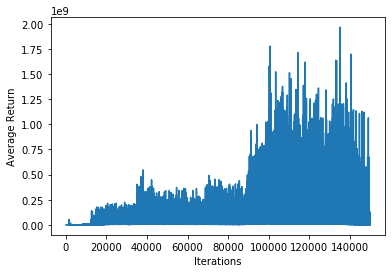

In [14]:
iterations = range(0, 10000 + 1, 1)
plt.plot(losses)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=10)

Text(0.5, 0, 'Iterations')

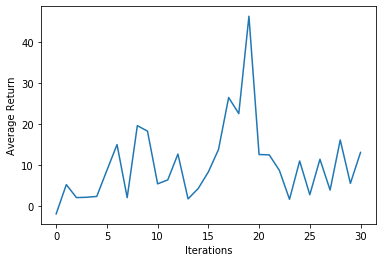

In [15]:
plt.plot(returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [16]:
for _ in range(1000):
    experience_replay.timestamp_data(env, agent.collect_policy)

Cumulated Reward: -12057.968108850846
Cumulated Reward: -64.98383883523594
Cumulated Reward: -2490.406397698968
Cumulated Reward: -100.31972583027935
Cumulated Reward: -137.2177372996804


#### 